In [1]:
using Pkg

In [2]:
Pkg.activate(dirname(pwd()))

  Activating environment at `~/Documents/GitHub/ComputationalHeatTransfer.jl/Project.toml`


In [3]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using CoolProp
using Interpolations
using JLD2
using Plots
gr()  

cd(dirname(pwd()))
cd("src") 
# includet("ComputationalHeatTransfer.jl")
# using ..ComputationalHeatTransfer
includet("OneDOHP.jl")
using ..OneDOHP

## Get fluid properties

In [4]:
fluid_type = "butane"
Tᵥ = 291.2

291.2

In [5]:
using UnPack

p_fluid = get_saturation_property(fluid_type,Tᵥ)
@unpack Cpₗ,ρₗ,μₗ,hₗ,kₗ,Prₗ,Cpᵥ,ρᵥ,μᵥ,hᵥ,kᵥ,Prᵥ,σ,P,R,M,Rkg,αₗ,νₗ,νᵥ,hₗᵥ = p_fluid;

## Read data

In [6]:
using JLD

In [33]:
# OHPdata = load("OHP1_40W.jld2")
# OHPdata = load("OHP1_40W_bothPe7.jld2")
# OHPdata = load("OHP1_40W_bothfine.jld2")
OHPdata = load("OHP2_30W_E070.jld2")



Dict{String, Any} with 6 entries:
  "integrator_tube"  => t: 159.279600004204…
  "integrator_plate" => t: 159.279600004204…
  "ohp"              => Basic pointwise-specified body with 4877 points…
  "tube_hist"        => Any[t: 0.39960000000000734…
  "plate_T_hist"     => Any[Primal nodes in a (nx = 250, ny = 108) cell grid of…
  "boil_data"        => [41.0 0.1; 48.0 0.1; … ; 123.0 159.2; 235.0 159.2]

In [34]:
tube_hist = OHPdata["tube_hist"]
plate_T_hist = OHPdata["plate_T_hist"]
# plate_hist = load("plate_OHP1_40W.jld2")
integrator_plate = OHPdata["integrator_plate"]
sys = integrator_plate.p

sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

In [35]:
# OHPdata = load("OHP2_40W.jld2")
# # sys = integrator_plate.p

# tube_hist = OHPdata["tube_hist"]
# plate_T_hist = OHPdata["plate_T_hist"]
# integrator_plate = OHPdata["integrator_plate"]
# sys = integrator_plate.p

# sysfinal = []
# for i = 1:length(tube_hist)
#     push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
# end

## Get RTD result for OHP

In [36]:
import XLSX

In [37]:
# xf = XLSX.readxlsx("20190613_F_PD_#004_O001_H001_P040_expA.xlsx")
# starti = 3603
# RTD = xf["Raw Data!G:N"][starti:end,:];
# RTDt = (1:size(RTD,1)) .+ starti;

In [38]:
# xf = XLSX.readxlsx("20190613_F_PD_#004_O001_H001_P040_expA.xlsx")
xf = XLSX.readxlsx("20190612_F_PD_#007_O002_H001_P030_expA.xlsx")
starti = 3603
# RTD = xf["Raw Data!G:N"][starti:end,:];
RTD = xf["Raw Data!U:AB"][starti:end,:];
RTDt = (1:size(RTD,1)) .+ starti;

In [39]:
inch = 2.54e-2;


# x = [-2.6inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.75inch]
x = [-2.75inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.75inch]
y = [0.0,0.0,0.0,0.0,0.4inch,0.0,0.0,0.0];

## Contour graphs

### plate T [K]

In [40]:
# Tmax = maximum(plate_T_hist[end][:])
# Tmin = minimum(plate_T_hist[1][:])

# l = @layout [a b ; c d]
# p1 = plot(plate_T_hist[5],sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),xlabelfontsize =5,ylabelfontsize =5,xtickfontsize=5,ytickfontsize=5,titlefontsize =5,line_z=0,xlabel="x [m]",ylabel="y [m]",title=string(round(tube_hist[5].t, digits=2), "[s]"))
# p2 = plot(plate_T_hist[25],sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),xlabelfontsize =5,ylabelfontsize =5,xtickfontsize=5,ytickfontsize=5,titlefontsize =5,line_z=0,xlabel="x [m]",ylabel="y [m]",title=string(round(tube_hist[25].t, digits=2), "[s]"))
# p3 = plot(plate_T_hist[100],sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),xlabelfontsize =5,ylabelfontsize =5,xtickfontsize=5,ytickfontsize=5,titlefontsize =5,line_z=0,xlabel="x [m]",ylabel="y [m]",title=string(round(tube_hist[100].t, digits=2), "[s]"))
# p4 = plot(plate_T_hist[300],sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),xlabelfontsize =5,ylabelfontsize =5,xtickfontsize=5,ytickfontsize=5,titlefontsize =5,line_z=0,xlabel="x [m]",ylabel="y [m]",title=string(round(tube_hist[300].t, digits=2), "[s]"))
# plot(p1, p2, p3, p4, layout = l)

In [41]:
# savefig("temperature_contour.pdf")

In [42]:
# rectangle(w, h, xx, yy) = Shape(xx .+ [0,w,w,0], yy .+ [0,0,h,h])
# @gif for i = 1:1:length(plate_T_hist)
# plot(plate_T_hist[i],sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(tube_hist[i].t, digits=2), "[s] \n",  "T[K]"))
# scatter!([x[1],x[4],x[8]],[y[1],y[4],y[8]])
# annotate!(x[1]+0.002, y[1]+0.005, "RTD1", :color)
# annotate!(x[4]+0.002, y[4]+0.005, "RTD4", :color)
# annotate!(x[8]+0.002, y[8]+0.005, "RTD8", :color,legend=false)
# plot!(rectangle(0.03,0.06,0.003,-0.03), opacity=.2, color=:red)
# plot!(rectangle(0.03,0.06,-0.033,-0.03), opacity=.2, color=:red)    
# plot!(rectangle(0.03,0.0648,0.05,-0.0324), opacity=.2, color=:blue)   
# end




In [43]:
# savefig("temperature_contour_withRTD.pdf")

In [44]:
# @gif for ii=1:1:length(sysfinal)
# #     plot(sysfinal[ii],plottype="T",ylim=(Tmin,Tmax),xlabel="ξ [m]",ylabel="T [K]",xlim=(0.0,0.5))
#     plot(sysfinal[ii],plottype="T",ylim=(291.0,293.0),xlabel="ξ [m]",ylabel="T [K]",xlim=(0.0,0.1))
# end
# # savefig("tubetemp.svg")

In [45]:
# @gif for ii=1:length(sysfinal)
#     plot(sysfinal[ii],plottype="ΔT",ylim=(-4.0,1.0))
#     plot!([0.0,sysfinal[ii].tube.L],[sysfinal[1].wall.ΔTthres,sysfinal[1].wall.ΔTthres],label="boiling threshold")
# end

### liquid slugs

In [46]:
# l = @layout [a b ; c d]
# Htmp = sys_to_Harray(sysfinal[5])
# p1   = plot(sys.qline[1].body,fillalpha=0,titlefontsize=10,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,title=string(round(tube_hist[5].t, digits=2), "[s]"),xlabel="x ",ylabel="y ",border=:none,axis=nothing)
# Htmp = sys_to_Harray(sysfinal[25])
# p2   = plot(sys.qline[1].body,fillalpha=0,titlefontsize=10,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,title=string(round(tube_hist[25].t, digits=2), "[s]"),xlabel="x ",ylabel="y ",border=:none,axis=nothing)
# Htmp = sys_to_Harray(sysfinal[100])
# p3   = plot(sys.qline[1].body,fillalpha=0,titlefontsize=10,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,title=string(round(tube_hist[100].t, digits=2), "[s]"),xlabel="x ",ylabel="y ",border=:none,axis=nothing)
# Htmp = sys_to_Harray(sysfinal[300])
# p4   = plot(sys.qline[1].body,fillalpha=0,titlefontsize=10,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,title=string(round(tube_hist[300].t, digits=2), "[s]"),xlabel="x ",ylabel="y ",border=:none,axis=nothing)
# plot(p1, p2, p3, p4, layout = l)

In [47]:
# savefig("liquidvapor.pdf")

### blue:liquid, yellow:vapor

In [48]:
# anim = @animate for i=1:1:length(sysfinal)
#     Htmp = sys_to_Harray(sysfinal[i])
#     plot(sys.qline[1].body,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,title=string(round(tube_hist[i].t, digits=2), "[s]"),xlabel="x ",ylabel="y ",border=:none,axis=nothing,label="asd")
# # plot!(rectangle(0.03,0.06,0.003,-0.03), opacity=.2, color=:red)
# # plot!(rectangle(0.03,0.06,-0.033,-0.03), opacity=.2, color=:red)    
# # plot!(rectangle(0.03,0.0648,0.05,-0.0324), opacity=.2, color=:blue)   
# end

In [49]:
# scatter(sysfinal[end].vapor.δ)
# scatter!(sysfinal[300].vapor.δ)
# plot!([0.0,24],[25e-6,25e-6])

In [50]:

#     Htmp = sys_to_Harray(sysfinal[i])
#     plot(sys.qline[1].body,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,title=string(round(tube_hist[i].t, digits=2), "[s]"),xlabel="x ",ylabel="y ",border=:none,axis=nothing,label="asd")
# plot!(rectangle(0.03,0.06,0.003,-0.03), opacity=.2, color=:red)
# plot!(rectangle(0.03,0.06,-0.033,-0.03), opacity=.2, color=:red)    
# plot!(rectangle(0.03,0.0648,0.05,-0.0324), opacity=.2, color=:blue)   
# # end

In [51]:
# @gif for i=1:1:length(sysfinal)
#     Htmp = sys_to_Harray(sysfinal[i])
#     plot(sys.qline[1].body,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,title=string(round(tube_hist[i].t, digits=2), "[s]"),xlabel="x ",ylabel="y ",border=:none,axis=nothing,label="asd")
# # plot!(rectangle(0.03,0.06,0.003,-0.03), opacity=.2, color=:red)
# # plot!(rectangle(0.03,0.06,-0.033,-0.03), opacity=.2, color=:red)    
# # plot!(rectangle(0.03,0.0648,0.05,-0.0324), opacity=.2, color=:blue)   
# end

In [52]:
# savefig("ohp.svg")

## get and save temperature line graph

In [53]:
X =  VectorData(x,y);

In [54]:
H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
g = ScalarData(X);

In [55]:
ghist = []
thist = []

size(g)
for j = 1:length(g)
    gtemp = []
    for i = 1:length(plate_T_hist)
        H(g,plate_T_hist[i])
        append!(gtemp,deepcopy(g[j]))
    end
    push!(ghist,deepcopy(gtemp))
end



thist = []
    for i = 1:length(tube_hist)
        append!(thist,tube_hist[i].t)
    end

In [56]:
save("OHP2_30W_e070_curve.jld2","thist",thist,"ghist",ghist)
# save("OHP2_40W_e095_curve.jld2","thist",thist,"ghist",ghist)

## Plot temperature curves

In [58]:
e000 = load("OHP2_30W_E0.jld2");
e075 = load("OHP2_30W_E75.jld2");
e095 = load("OHP2_30W_E95.jld2");
e100 = load("OHP2_30W_E1.jld2");
e068 = load("OHP2_30W_e068_curve.jld2");
e070 = load("OHP2_30W_e070_curve.jld2");

In [20]:
l = @layout [a b; c d]

2×2 Matrix{Any}:
 (label = :a, blank = false)  (label = :b, blank = false)
 (label = :c, blank = false)  (label = :d, blank = false)

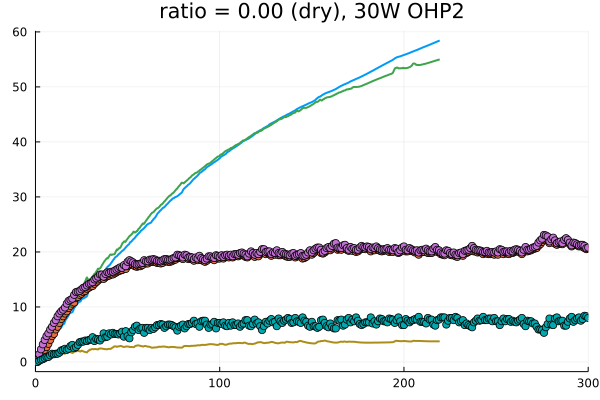

In [21]:
i = 1 #RTD number

p1 = plot(e000["thist"],e000["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2,legend=false)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,50.0))

i = 4 #RTD number

plot!(e000["thist"],e000["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,50.0))

i = 8 #RTD number
plot!(e000["thist"],e000["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,300.0),title=("ratio = 0.00 (dry), 30W OHP2"))

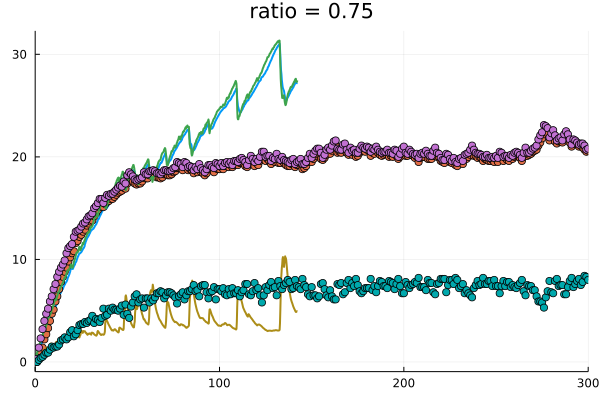

In [22]:
i = 1 #RTD number

p2 = plot(e075["thist"],e075["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2,legend=false)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,50.0))

i = 4 #RTD number

plot!(e075["thist"],e075["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,50.0))

i = 8 #RTD number
plot!(e075["thist"],e075["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,300.0),title=("ratio = 0.75"))

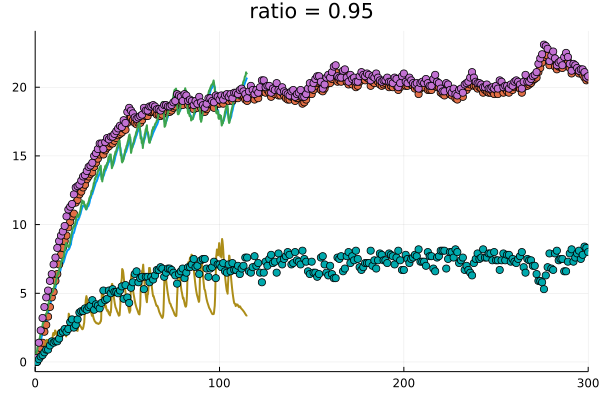

In [23]:
i = 1 #RTD number

p3 = plot(e095["thist"],e095["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2,legend=false)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,50.0))

i = 4 #RTD number

plot!(e095["thist"],e095["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,50.0))

i = 8 #RTD number
plot!(e095["thist"],e095["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,300.0),title=("ratio = 0.95"))

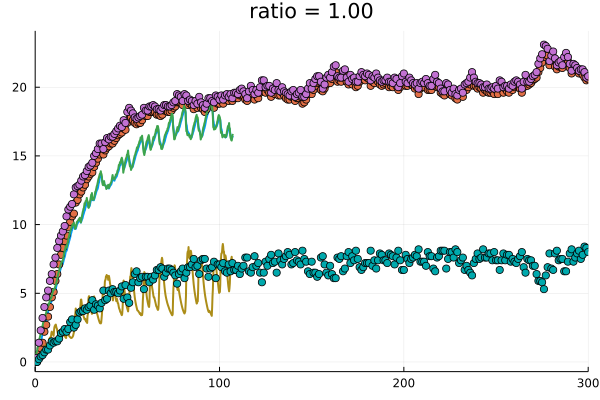

In [27]:
i = 1 #RTD number

p4 = plot(e100["thist"],e100["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2,legend=false)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,50.0))

i = 4 #RTD number

plot!(e100["thist"],e100["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,50.0))

i = 8 #RTD number
plot!(e100["thist"],e100["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,300.0),title=("ratio = 1.00"))

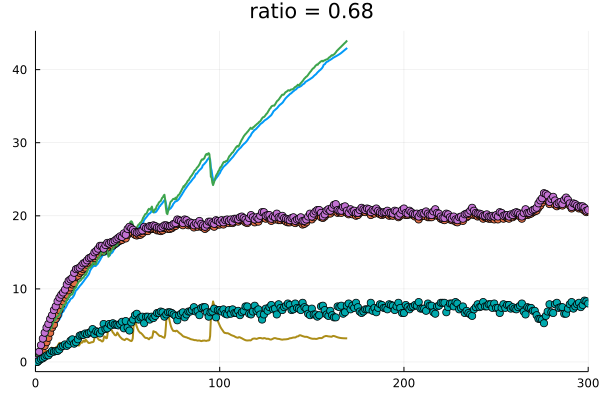

In [31]:
i = 1 #RTD number

p5 = plot(e068["thist"],e068["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2,legend=false)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,50.0))

i = 4 #RTD number

plot!(e068["thist"],e068["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,50.0))

i = 8 #RTD number
plot!(e068["thist"],e068["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,300.0),title=("ratio = 0.68"))

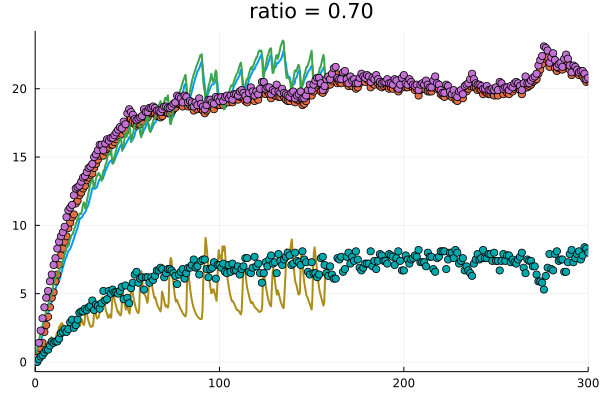

In [60]:
i = 1 #RTD number

p6 = plot(e070["thist"],e070["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2,legend=false)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,50.0))

i = 4 #RTD number

plot!(e070["thist"],e070["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,50.0))

i = 8 #RTD number
plot!(e070["thist"],e070["ghist"][i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,300.0),title=("ratio = 0.70"))

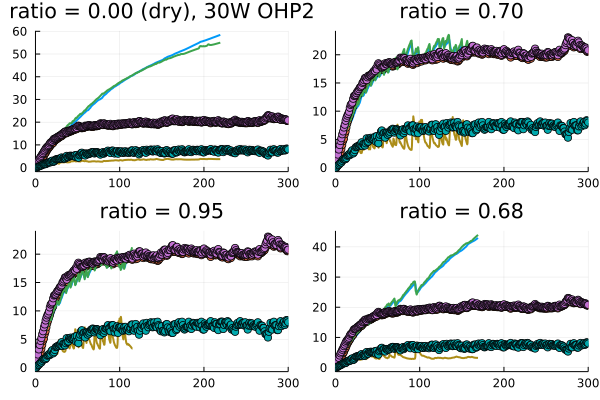

In [61]:
plot(p1, p6, p3, p5, layout = l)

In [79]:
# savefig("Tempcurves.pdf")

## ~heat ressistance curves

In [80]:
power = 30

30

In [100]:
i1 = 4 #RTD number
i2 = 8 #RTD number

8

In [101]:

# plot(Pe4["thist"], power ./ (Pe4["ghist"][i1] .-Pe4["ghist"][i2]),label=string("40 Watt heater simulation Pe4"),linewidth=2,ylim=(0,15))
# plot!(Pe6["thist"], power ./ (Pe6["ghist"][i1] .-Pe6["ghist"][i2]),label=string("40 Watt heater simulation Pe6"),linewidth=2,ylim=(0,15))
# plot!(Pe7["thist"], power ./ (Pe7["ghist"][i1] .-Pe7["ghist"][i2]),label=string("40 Watt heater simulation Pe7"),linewidth=2,ylim=(0,15))
# plot!(Pe8["thist"], power ./ (Pe8["ghist"][i1] .-Pe8["ghist"][i2]),label=string("40 Watt heater simulation Pe8"),linewidth=2,ylim=(0,15))
# # scatter!(RTDt .- RTDt[1],power ./(RTD[:,i1] .- RTD[:,i2]), label=string("40 Watt heater experiment"),legend=:topright,xlim=(thist[1],thist[end]),title="thermal conductance ",xlabel="time [s]",ylabel="P/(T₄-T₈) [W/K]")

In [102]:
power ./(RTD[:,i1] .- RTD[:,i2])

3600-element Vector{Float64}:
 150.00000000000853
  60.0
  21.428571428571775
  14.28571428571413
  10.344827586206979
   8.571428571428571
   7.5
   6.666666666666667
   6.122448979591865
   5.88235294117651
   5.084745762711835
   4.761904761904753
   4.285714285714286
   ⋮
   2.4793388429752135
   2.3809523809523765
   2.3255813953488413
   2.4390243902439
   2.419354838709671
   2.4390243902439
   2.173913043478259
   2.2900763358778584
   2.189781021897812
   2.36220472440944
   2.5210084033613493
   2.479338842975202

In [103]:
RTDt .- RTDt[1]

0:3599

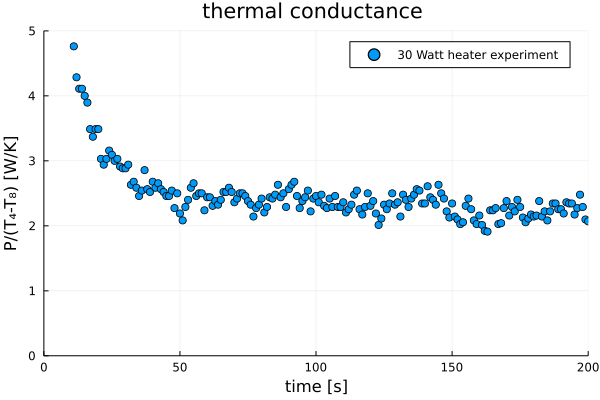

In [108]:
# plot!(thist_Conserve_H2250_D1_TH1,ghist_Conserve_H2250_D1_TH1[i1] .-ghist_Conserve_H2250_D1_TH1[i2],label=string("RTD", i," flim δ=10 μm, ΔT=1.0 [K], Hc = 2250 [W/K], plate d = 1.5 [mm]"),linewidth=2)
scatter(RTDt .- RTDt[1],power ./(RTD[:,i1] .- RTD[:,i2]), label=string("30 Watt heater experiment"),legend=:topright,ylim=(0,5),title="thermal conductance ",xlim=(0,200),xlabel="time [s]",ylabel="P/(T₄-T₈) [W/K]")

In [91]:
i1 = 4 #RTD number
i2 = 1 #RTD number
# plot(thist, power ./ (ghist[i1] .-ghist[i2]),label=string("40 Watt heater simulation"),linewidth=2,ylim=(0,15))
# plot(thist_DT1_H3000_Film3_F1_Nu436_plated_2, power ./ (ghist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2[i1] .-ghist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2[i2]),label=string("40 Watt heater simulation"),linewidth=2,ylim=(0,15))
# plot(thist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2,ghist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2[i1] .-ghist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2[i2],label=string("RTD", i," flim δ=30 μm, ΔT=1.0 [K], Hc = 3000 [W/K], plate d = 2 [mm]"),linewidth=2)
# plot!(thist_conserve_DT2_H4000_Film3_F1_Nu436_plated_15,ghist_conserve_DT2_H4000_Film3_F1_Nu436_plated_15[i] .-Tᵥ,label=string("RTD", i," flim δ=30 μm, ΔT=2.0 [K], Hc = 4000 [W/K], plate d = 1.5 [mm]"),linewidth=2)
# plot!(thist_Conserve_H2250_D1_TH1,ghist_Conserve_H2250_D1_TH1[i1] .-ghist_Conserve_H2250_D1_TH1[i2],label=string("RTD", i," flim δ=10 μm, ΔT=1.0 [K], Hc = 2250 [W/K], plate d = 1.5 [mm]"),linewidth=2)
scatter(RTDt .- RTDt[1],power ./(RTD[:,i1] .- RTD[:,i2]), label=string("40 Watt heater experiment"),legend=:topright,xlim=(thist[1],thist[end]),title="thermal conductance ",xlabel="time [s]",ylabel="P/(T₄-T₈) [W/K]")

LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [1]

In [ ]:
# savefig("thermal_conductance.pdf")

## Plot temperature curves

In [ ]:
i = 1 #RTD number

plot(thist,ghist[i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
# plot(thist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2,ghist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2[i] .-Tᵥ,label=string("RTD", i," flim δ=30 μm, ΔT=1.0 [K], Hc = 3000 [W/K], plate d = 2 [mm]"),linewidth=2)
# plot!(thist_conserve_DT2_H4000_Film3_F1_Nu436_plated_15,ghist_conserve_DT2_H4000_Film3_F1_Nu436_plated_15[i] .-Tᵥ,label=string("RTD", i," flim δ=30 μm, ΔT=2.0 [K], Hc = 4000 [W/K], plate d = 1.5 [mm]"),linewidth=2)
# plot!(thist_Conserve_H2250_D1_TH1,ghist_Conserve_H2250_D1_TH1[i] .-Tᵥ,label=string("RTD", i," flim δ=10 μm, ΔT=1.0 [K], Hc = 2250 [W/K], plate d = 1.5 [mm]"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,50.0))

i = 4 #RTD number

plot!(thist,ghist[i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
# plot(thist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2,ghist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2[i] .-Tᵥ,label=string("RTD", i," flim δ=30 μm, ΔT=1.0 [K], Hc = 3000 [W/K], plate d = 2 [mm]"),linewidth=2)
# plot!(thist_conserve_DT2_H4000_Film3_F1_Nu436_plated_15,ghist_conserve_DT2_H4000_Film3_F1_Nu436_plated_15[i] .-Tᵥ,label=string("RTD", i," flim δ=30 μm, ΔT=2.0 [K], Hc = 4000 [W/K], plate d = 1.5 [mm]"),linewidth=2)
# plot!(thist_Conserve_H2250_D1_TH1,ghist_Conserve_H2250_D1_TH1[i] .-Tᵥ,label=string("RTD", i," flim δ=10 μm, ΔT=1.0 [K], Hc = 2250 [W/K], plate d = 1.5 [mm]"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,50.0))

i = 8 #RTD number
plot!(thist,ghist[i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
# plot!(thist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2,ghist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2[i] .-Tᵥ,label=string("RTD", i," flim δ=30 μm, ΔT=1.0 [K], Hc = 3000 [W/K], plate d = 2 [mm]"),linewidth=2)
# plot!(thist_conserve_DT2_H4000_Film3_F1_Nu436_plated_15,ghist_conserve_DT2_H4000_Film3_F1_Nu436_plated_15[i] .-Tᵥ,label=string("RTD", i," flim δ=30 μm, ΔT=2.0 [K], Hc = 4000 [W/K], plate d = 1.5 [mm]"),linewidth=2)
# plot!(thist_Conserve_H2250_D1_TH1,ghist_Conserve_H2250_D1_TH1[i] .-Tᵥ,label=string("RTD", i," flim δ=10 μm, ΔT=1.0 [K], Hc = 2250 [W/K], plate d = 1.5 [mm]"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i],legend=:topleft, label=string("RTD", i," experiment"),title= "40W, hc = (300,3000), superheat = 1.8K",xlim=(0.0,400.0),xlabel="time[s]",ylabel="T-T0[K]")

In [ ]:
savefig("Tempcurves.svg")

## ~heat ressistance curves

In [ ]:
power = 40

In [ ]:
i1 = 4 #RTD number
i2 = 8 #RTD number
plot(thist, power ./ (ghist[i1] .-ghist[i2]),label=string("40 Watt heater simulation"),linewidth=2,ylim=(0,15))
# plot(thist_DT1_H3000_Film3_F1_Nu436_plated_2, power ./ (ghist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2[i1] .-ghist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2[i2]),label=string("40 Watt heater simulation"),linewidth=2,ylim=(0,15))
# plot(thist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2,ghist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2[i1] .-ghist_conserve_DT1_H3000_Film3_F1_Nu436_plated_2[i2],label=string("RTD", i," flim δ=30 μm, ΔT=1.0 [K], Hc = 3000 [W/K], plate d = 2 [mm]"),linewidth=2)
# plot!(thist_conserve_DT2_H4000_Film3_F1_Nu436_plated_15,ghist_conserve_DT2_H4000_Film3_F1_Nu436_plated_15[i] .-Tᵥ,label=string("RTD", i," flim δ=30 μm, ΔT=2.0 [K], Hc = 4000 [W/K], plate d = 1.5 [mm]"),linewidth=2)
# plot!(thist_Conserve_H2250_D1_TH1,ghist_Conserve_H2250_D1_TH1[i1] .-ghist_Conserve_H2250_D1_TH1[i2],label=string("RTD", i," flim δ=10 μm, ΔT=1.0 [K], Hc = 2250 [W/K], plate d = 1.5 [mm]"),linewidth=2)
scatter!(RTDt .- RTDt[1],power ./(RTD[:,i1] .- RTD[:,i2]), label=string("40 Watt heater experiment"),legend=:topright,xlim=(0.0,400.0),title="thermal conductance ",xlabel="time [s]",ylabel="P/(T₄-T₁) [W/K]")

## film δ distribution

In [ ]:
addindex = 50:1:300
δArray = []
for i in addindex
δArray = [δArray;sysfinal[i].vapor.δ]
end

In [ ]:
histogram(δArray,bins=2.0e-5:0.25e-6:3.0e-5,title="sum of δ from 50[s] : 1[s] : 100[s]",legend=false,xlabel="δ [m]",ylabel="N of vapor") 

In [ ]:
savefig("sum_film_thickness.svg")

In [ ]:
sysfinal[end].vapor.δ

In [ ]:
l = @layout [a b ; c d]
pltindex=[5,25,100,300]
p1 = histogram(sysfinal[pltindex[1]].vapor.δ,bins=2.5e-5:0.25e-6:3.5e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[1]].t, digits=2), "[s]")) 
p2 = histogram(sysfinal[pltindex[2]].vapor.δ,bins=2.5e-5:0.25e-6:3.5e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[2]].t, digits=2), "[s]")) 
p3 = histogram(sysfinal[pltindex[3]].vapor.δ,bins=2.5e-5:0.25e-6:3.5e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[3]].t, digits=2), "[s]")) 
p4 = histogram(sysfinal[pltindex[4]].vapor.δ,bins=2.5e-5:0.25e-6:3.5e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[4]].t, digits=2), "[s]")) 
plot(p1, p2, p3, p4, layout = l,titlefontsize=10,labelfontsize=10,xticks=2.5e-5:0.5e-5:3.5e-5,legend=false,xlabel="δ [m]",ylabel="N of vapor",plot_title="film thickness histogram")

In [ ]:
savefig("film_histogram.pdf")

## dXdt distribution

In [ ]:
V = [elem[2] for elem in sysfinal[end-5].liquid.dXdt]
Vavg = sum(abs.(V))/length(V)

In [ ]:
addindex = 50:1:100
VArray = []
for i in addindex
VArray = [VArray;[elem[2] for elem in sysfinal[i].liquid.dXdt]]
end

In [ ]:
density  = fitdensity(VArray,step=0.1,norm=1)

In [ ]:
plot(density.x,density.d)

In [ ]:
histogram(VArray,title="sum of interface V from 50[s] : 1[s] : 100[s]",legend=false,xlabel="dXdt [m/s]",ylabel="N of liquid") 

In [ ]:
savefig("sum_interface_V.svg")

In [ ]:
([elem[1] for elem in sysfinal[pltindex[1]].liquid.dXdt]-[elem[2] for elem in sysfinal[pltindex[1]].liquid.dXdt])./[elem[1] for elem in sysfinal[pltindex[1]].liquid.dXdt]

In [ ]:
l = @layout [a b ; c d]
pltindex=[5,25,100,300]
p1 = histogram([elem[1] for elem in sysfinal[pltindex[1]].liquid.dXdt],bins=-2:0.1:2,ylim=(0,20),title=string(round(tube_hist[pltindex[1]].t, digits=2), "[s]")) 
p2 = histogram([elem[1] for elem in sysfinal[pltindex[2]].liquid.dXdt],bins=-2:0.1:2,ylim=(0,20),title=string(round(tube_hist[pltindex[2]].t, digits=2), "[s]")) 
p3 = histogram([elem[1] for elem in sysfinal[pltindex[3]].liquid.dXdt],bins=-2:0.1:2,ylim=(0,20),title=string(round(tube_hist[pltindex[3]].t, digits=2), "[s]")) 
p4 = histogram([elem[1] for elem in sysfinal[pltindex[4]].liquid.dXdt],bins=-2:0.1:2,ylim=(0,20),title=string(round(tube_hist[pltindex[4]].t, digits=2), "[s]")) 
plot(p1, p2, p3, p4, layout = l,titlefontsize=10,labelfontsize=10,legend=false,xlabel="dXdt [m/s]",ylabel="N of liquid",plot_title="liquid slug velocity histogram")

In [ ]:
savefig("bulkV_histogram.pdf")

## correlated film δ

In [ ]:
l = @layout [a b ; c d]
pltindex=[5,15,25,590]
p1 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[1]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:3e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[1]].t, digits=2), "[s]")) 
p2 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[2]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:3e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[2]].t, digits=2), "[s]")) 
p3 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[3]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:3e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[3]].t, digits=2), "[s]")) 
p4 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[4]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:3e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[4]].t, digits=2), "[s]")) 
plot(p1, p2, p3, p4, layout = l,titlefontsize=10,labelfontsize=10,xticks=1e-5:2e-5:5e-5,legend=false,xlabel="δ [m]",ylabel="N of vapor",plot_title="film thickness histogram from Ca correlarion")

## OHP animation

In [ ]:
ρ = 2700;
c = 8.97e02;
k = 1.67e02;
d = 2e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

In [ ]:
Δx = cellsize(sys)
ds = 1.5Δx
nturn = 16
#pitch = 0.125
length_ohp = 44.25*1e-3
height = 133.83*1e-3
gap = d
pitch = length_ohp/(2*nturn+1)
x0, y0 = height/2, length_ohp/2
x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,3pi/2)
ohp = BasicBody(x,y)

In [ ]:
sys.points

In [ ]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing,title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  "T[K]"))
end

## OHP film thickness correlation

In [ ]:
integrator_tube.p.vapor.δ

In [ ]:

velocity_avg = zeros(length(sysfinal))
velocity_max = zeros(length(sysfinal))

for i = 1:length(sysfinal)
    tmp = 0
    for j = length(sysfinal[i].liquid.dXdt)
        tmp += abs(sysfinal[i].liquid.dXdt[j][1])
    
        velocity_avg[i] = tmp/j
    end
    
    velocity_max[i] = maximum(abs.(sysfinal[i].liquid.dXdt[:][1]))
end



In [ ]:
μₗ

In [ ]:
Ca = velocity_max .* μₗ ./σ

In [ ]:
plot(thist,velocity_avg,label="v avg")
plot!(thist,velocity_max,label="v max",xlabel="t [s]", ylabel="v [m/s]")

In [ ]:
d_tube = sysfinal[end].tube.d

### Range of Re
### $Re = \frac{\rho_{\mathrm{l}} v d}{\mu_{\mathrm{l}}}$



In [ ]:
Re_avg = d_tube*ρₗ .* velocity_avg / μₗ
Re_max = d_tube*ρₗ .* velocity_max / μₗ;

In [ ]:
plot(thist,Re_avg,label="v avg")
plot!(thist,Re_max,label="v max",xlabel="t [s]", ylabel="Re")

In [ ]:
integrator_tube.p.vapor.δ

In [ ]:
δ_corr = integrator_tube.p.tube.d * (0.67 .* Ca.^(2/3)) ./ ( 1 .+ 3.35 .* Ca.^(2/3))

In [ ]:
δ_corr = integrator_tube.p.tube.d * (0.67 .* Ca2.^(2/3)) ./ ( 1 .+ 3.35 .* Ca2.^(2/3))

In [ ]:
U = 0.4 #m/s

Ca2 = U .* μₗ ./σ

In [ ]:
tube_d = 1e-3

In [ ]:
Ca_star1 = (μₗ^2/(σ * ρₗ * tube_d/2))^(3/4)

In [ ]:
Ca_star2 = (μₗ^2/(σ * ρₗ * tube_d/2))^(1/2)

In [ ]:
sysfinal[1].wall.ΔTthres

In [ ]:
sysfinal[1].vapor.δ

In [ ]:
l = @layout [a b ; c d]
pltindex=[5,15,25,100]
p1 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[1]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:5e-5,ylim=(0,20),title=string("t=",round(plate_hist[pltindex[1]].t, digits=2), "[s]")) 
p2 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[2]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:5e-5,ylim=(0,20),title=string("t=",round(plate_hist[pltindex[2]].t, digits=2), "[s]")) 
p3 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[3]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:5e-5,ylim=(0,20),title=string("t=",round(plate_hist[pltindex[3]].t, digits=2), "[s]")) 
p4 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[4]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:5e-5,ylim=(0,20),title=string("t=",round(plate_hist[pltindex[4]].t, digits=2), "[s]")) 
plot(p1, p2, p3, p4, layout = l,titlefontsize=10,labelfontsize=10,xticks=1e-5:2e-5:5e-5,legend=false,xlabel="δ [m]",ylabel="N of vapor",plot_title="film thickness histogram")

In [ ]:
i = 100
velocity = 
Ca = 

plot(δfilm)

In [ ]:
velocity = [elem[1] for i =1:]getCa(μ,σ,velocity)

In [ ]:
ρₗ-ρᵥ

In [ ]:
bo = (ρₗ-ρᵥ).*9.8*(1e-3)^2/σ

In [ ]:
μₗ.*1.0/σ

In [ ]:
function getCa(μ,σ,velocity)
    Ca = abs.(μ.*velocity./σ)
end

function filmδcorr(Ca,d)
    filmδ = d .* 0.67.*Ca.^(2/3)./(1 .+ 3.35.*Ca.^(2/3))
end

## Film thickness graphs

In [ ]:
@gif for i=length(sysfinal):length(sysfinal)
    plot(sysfinal[i].vapor.δ,xlabel="vapor label",ylabel="film thickness [m]", label = "δ",ylim=(5e-6,1.5e-5))
end

## boiling graph

In [ ]:
boil_data = load("OHP1_40W.jld2","boil_data");

In [ ]:
Xstations = sysfinal[end].wall.Xstations;

In [ ]:
tend = boil_data[end,2]
boil_dt = 0.1;

In [ ]:
using SparseArrays 

In [ ]:
boil_matrix=spzeros(size(Xstations,1),Int64(round(tend/boil_dt)));
for tnum = 1:size(boil_matrix,2)
     boil_index = findall(x->Int64(round(x/boil_dt))==tnum,boil_data[:,2])

    if length(boil_index) != 0
        i_station_temp = Int64.(boil_data[boil_index,1])
        for i in i_station_temp
            boil_matrix[i,tnum] = 1
        end
    end
end


In [ ]:
boil_num_t = sum(boil_matrix, dims=1)'
boil_num_x = sum(boil_matrix, dims=2);

In [ ]:
using EasyFit

m10 = movavg(vec(boil_num_t),10)


In [ ]:
m10.R

In [ ]:
plot(0.1:0.1:300.0,m10.x,xlabel="t",ylabel="N",title="number of active boiling sites (moving averaged)",legend=false)

In [ ]:
savefig("boiling frequency.pdf")

In [ ]:
boiling

In [ ]:
num_boiling = zeros(size(Xstations))
for i = 1:size(boil_data,1)
    num_boiling[Int64(sorted_boil_hist[i,1])] += 1
end
freq_boiling = num_boiling/tend;

In [ ]:
sorted_boil_hist = boil_data[sortperm(boil_data[:, 1]), :]
num_boiling = zeros(size(Xstations))
for i = 1:size(sorted_boil_hist,1)
    num_boiling[Int64(sorted_boil_hist[i,1])] += 1
end
freq_boiling = num_boiling/tend;

In [ ]:
scatter(xstations,freq_boiling,xlabel="x[m]",ylabel="boiling frequency [HZ]",legend=false)

In [ ]:
scatter(ystations,freq_boiling,xlabel="y[m]",ylabel="boiling frequency [HZ]",legend=false)

In [ ]:
ohp = load("ohp.jld2","ohp")

In [ ]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
# Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


In [ ]:
plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)
scatter!(xstations,ystations)

In [ ]:
savefig("boiling sites.svg")

In [ ]:
ql = sys.qline[1]
interp_linear_x = LinearInterpolation(ql.arccoord, ql.body.x,extrapolation_bc = Line());
interp_linear_y = LinearInterpolation(ql.arccoord, ql.body.y,extrapolation_bc = Line());

xstations = interp_linear_x[sysfinal[end].wall.Xstations]
ystations = interp_linear_y[sysfinal[end].wall.Xstations]

In [ ]:
Lliquid = XptoLliquidslug(sysfinal[end].liquid.Xp,sysfinal[end].tube.L)

sum(Lliquid)/sysfinal[end].tube.L

In [ ]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [ ]:
plate_d = 2e-3
tube_d = 1e-3

In [ ]:
(Lx*Ly*plate_d - sysfinal[1].tube.L * tube_d^2)/(Lx*Ly)